/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


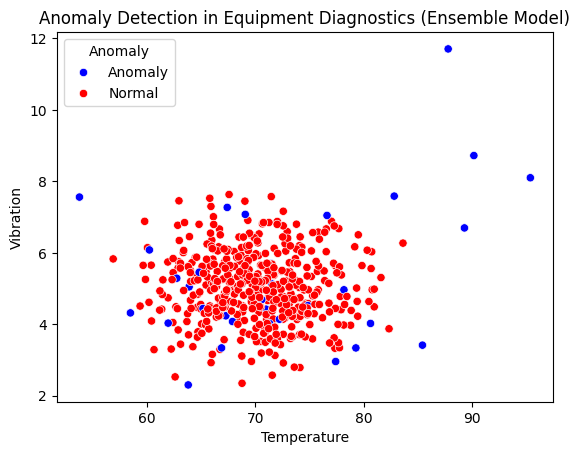

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Генерация данных для температур, вибраций, давления и других параметров
np.random.seed(42)
n_samples = 500
temperature = np.random.normal(70, 5, n_samples)    # Температура
vibration = np.random.normal(5, 1, n_samples)        # Вибрация
pressure = np.random.normal(1, 0.1, n_samples)       # Давление
humidity = np.random.normal(0.3, 0.05, n_samples)    # Влажность
noise_level = np.random.normal(0, 0.1, n_samples)    # Уровень шума

# Искусственно добавим аномалии каждые 100 точек
temperature[::100] += np.random.normal(20, 5, 5)
vibration[::100] += np.random.normal(3, 1, 5)
pressure[::100] += np.random.normal(0.5, 0.1, 5)

# Соберем данные в DataFrame
data = pd.DataFrame({
    'Temperature': temperature,
    'Vibration': vibration,
    'Pressure': pressure,
    'Humidity': humidity,
    'Noise': noise_level
})

# 2. Стандартизация данных
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# 3. Применение ансамбля моделей

# Isolation Forest
isolation_forest = IsolationForest(contamination=0.05)
data['IF_Anomaly'] = isolation_forest.fit_predict(scaled_data)

# Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
data['LOF_Anomaly'] = lof.fit_predict(scaled_data)

# PCA для выявления аномалий через реконструкцию ошибки
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Добавим метки аномалий с использованием различных методов (усреднённое значение)
data['Ensemble_Anomaly'] = (data[['IF_Anomaly', 'LOF_Anomaly']].sum(axis=1) <= -1).astype(int)

# 4. Автоэнкодер для выявления аномалий
autoencoder = Sequential([
    Dense(8, activation='relu', input_shape=(scaled_data.shape[1],)),
    Dense(4, activation='relu'),
    Dense(2, activation='relu'),
    Dense(4, activation='relu'),
    Dense(8, activation='relu'),
    Dense(scaled_data.shape[1], activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(scaled_data, scaled_data, epochs=50, batch_size=32, verbose=0)

# Ошибка реконструкции
reconstructions = autoencoder.predict(scaled_data)
mse = np.mean(np.power(scaled_data - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 95)
data['AE_Anomaly'] = (mse > threshold).astype(int)

# 5. Визуализация аномалий (с использованием ансамбля и автоэнкодера)
data['Anomaly'] = (data[['Ensemble_Anomaly', 'AE_Anomaly']].sum(axis=1) > 0).map({True: 'Anomaly', False: 'Normal'})

sns.scatterplot(x=data['Temperature'], y=data['Vibration'], hue=data['Anomaly'], palette=['blue', 'red'])
plt.title("Anomaly Detection in Equipment Diagnostics (Ensemble Model)")
plt.xlabel("Temperature")
plt.ylabel("Vibration")
plt.show()
